In [ ]:
#%tensorflow_version 2.x

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
import sys
projectDir = "/content/drive/My Drive/code/git/tweepfake_deepfake_text_detection"
sys.path.insert(0, projectDir)

random_state = 523 # Fixed seed for replicability of randomic operations.
resultsDir = projectDir+"/data/results"

In [ ]:
%%writefile setup.sh

export CUDA_HOME=/usr/local/cuda-10.1
git clone https://github.com/NVIDIA/apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

Writing setup.sh


In [ ]:
!sh setup.sh

Cloning into 'apex'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 7367 (delta 3), reused 0 (delta 0), pack-reused 7353
Receiving objects: 100% (7367/7367), 13.89 MiB | 12.96 MiB/s, done.
Resolving deltas: 100% (4974/4974), done.
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-7hv0pjtc
Created temporary directory: /tmp/pip-req-tracker-7sxrwyld
Created requirements tracker '/tmp/pip-req-tracker-7sxrwyld'
Created temporary directory: /tmp/pip-install-069661w0
Processing ./apex
  Created temporary directory: /tmp/pip-req-build-ng7xpxj1
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-7sxrwyld'
    Running setup.py (path:/t

In [ ]:
!pip install pandas transformers simpletransformers==0.41 amp

     |████████████████████████████████| 778kB 6.0MB/s 
     |████████████████████████████████| 194kB 18.4MB/s 
     |████████████████████████████████| 3.0MB 18.2MB/s 
     |████████████████████████████████| 1.1MB 38.6MB/s 
     |████████████████████████████████| 890kB 44.8MB/s 
     |████████████████████████████████| 317kB 36.8MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 163kB 38.6MB/s 
  Created wheel for amp: filename=AMP-1.1.4-cp36-none-any.whl size=9417 sha256=c9557a8794a524b04d45830a2e9cde203533a9f3689302bb302fb3b9f301768f
  Stored in directory: /root/.cache/pip/wheels/c4/9c/a0/acaeece5c47a0249f6152849c2e694fee9afbb43a8864b9128
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=5fed0c3a584a937fc040af7bd190ca833639a3ee5b6473b7d3235467f6ab2846
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
  Created wheel for seqeval: filenam

In [ ]:
from DataHandler import DataHandler

csvTrainDataset = projectDir+"/data/splits/train.csv"
csvValDataset = projectDir+"/data/splits/validation.csv"
csvTestDataset = projectDir+"/data/splits/test.csv"

bertDir = projectDir+"/data/encoded/bert"
dh = DataHandler()
dfTrain = dh.readCSVData(csvTrainDataset)
dfVal = dh.readCSVData(csvValDataset)
dfTest = dh.readCSVData(csvTestDataset)

In [ ]:
dfTrain

,N_prog,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favorite_count,retweet_count,quote_count,reply_count,hashtags,symbols,urls_url,urls_t.co,urls_expanded_url,media_url,media_t.co,media_expanded_url,media_type,ext_media_url,ext_media_t.co,ext_media_expanded_url,ext_media_type,mentions_user_id,mentions_screen_name,lang,quoted_status_id,quoted_text,quoted_created_at,quoted_source,quoted_favorite_count,quoted_retweet_count,quoted_user_id,...,place_url,place_name,place_full_name,place_type,country,country_code,geo_coords,coords_coords,bbox_coords,status_url,name,location,description,url,protected,followers_count,friends_count,listed_count,statuses_count,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,created,data.tweet,ora.tweet,tweet_type,mention_TF,hashtag_TF,url_TF,n.words,punct,account.type,finetuning_source,class_type
0,14692,x1110407881030017024,x1208265880146046976,2019-12-21 06:00:08,imranyebot,YEA now that note GOOD,imranye-twitter-bot,22,NaN,NaN,NaN,False,False,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA,NA NA NA NA NA NA NA NA,https://twitter.com/imranyebot/status/12082658...,imranyebot,NaN,@imranye in robot form. tweets every hour gene...,NaN,False,29,3,0,7467,0,2019-03-26 05:07:23,False,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/1110408254...,2019-12-21 06:00:08,2019-12-21,06:00:08,tweet,False,False,False,5,0,bot,imranye,others
1,22336,x3171109449,x1091463908118941696,2019-02-01 22:30:48,zawvrk,Listen to This Charming Man by The Smiths htt...,Twitter for iPhone,66,NaN,NaN,NaN,False,False,4,0,NaN,NaN,NaN,NaN,soundcloud.com/thesmiths/this…,https://t.co/r12OIXkfUO,https://soundcloud.com/thesmiths/this-charming...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA,NA NA NA NA NA NA NA NA,https://twitter.com/zawvrk/status/109146390811...,zawar,NaN,gold experience,https://t.co/J60plTSsKt,False,558,274,8,12216,23633,2015-04-15 19:50:16,False,https://t.co/J60plTSsKt,https://www.instagram.com/zawvr,NaN,https://pbs.twimg.com/profile_banners/31711094...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1229957200...,2019-02-01 22:30:48,2019-02-01,22:30:48,tweet,False,False,True,13,3,human,original,human
2,24087,x1110686081341632512,x1199055191028293633,2019-11-25 20:00:09,zawarbot,wish i can i would be seeing other hoes on the...,zawar-twitter-bot,57,NaN,NaN,NaN,False,False,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA,NA NA NA NA NA NA NA NA,https://twitter.com/zawarbot/status/1199055191...,zawarbot,NaN,I’m an AI Bot that tries to tweet like @zawvrk...,NaN,False,13,7,0,4054,9,2019-03-26 23:32:52,False,NaN,NaN,NaN,NaN,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1185589257...,2019-11-25 20:00:09,2019-11-25,20:00:09,tweet,False,False,False,13,0,bot,zawvrk,others
3,7584,x1110307772783124480,x1214698264701722626,2020-01-08 00:00:08,ahadsheriffbot,The decade in the significantly easier schedul...,ahadsheriff-bot,63,NaN,NaN,NaN,False,False,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA,NA NA NA NA NA NA NA NA,https://twitter.com/ahadsheriffbot/status/1214...,Robot Ahad Sheriff,NaN,@ahadsheriff in robot form. tweets every hour ...,https://t.co/2G243YsNOt,False,18,1,0,7946,0,2019-03-25 22:29:36,False,https://t.co/2G243YsNOt,https://ahadsheriff.com,NaN,NaN,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1110311752...,2020-01-08 00:00:08,2020-01-08,00:00:08,tweet,Fa

In [ ]:
# Select interesting columns for this study.
dfTrainDataset = dfTrain[["screen_name", "text", "account.type"]]
dfValDataset = dfVal[["screen_name", "text", "account.type"]]
dfTestDataset = dfTest[["screen_name", "text", "account.type"]]

In [ ]:
dfTrainDataset

,screen_name,text,account.type
0,imranyebot,YEA now that note GOOD,bot
1,zawvrk,Listen to This Charming Man by The Smiths htt...,human
2,zawarbot,wish i can i would be seeing other hoes on the...,bot
3,ahadsheriffbot,The decade in the significantly easier schedul...,bot
4,kevinhookebot,"""Theim class=\""alignnone size-full wp-image-60...",bot
...,...,...,...
20707,AINarendraModi,Met on the Abversion of our science for the co...,bot
20708,AINarendraModi,Land for their during the opportunity to the p...,bot
20709,DeepDrumpf,@TayandYou doesn't have a clue. You're right. ...,bot
20710,jaden,Me And My Bestie https://t.co/vPq2iDkWZm,human


In [ ]:
X_train_all = dfTrainDataset.drop(columns=['screen_name'])
X_train_all.columns = ["text", "label"]

X_val_all = dfValDataset.drop(columns=['screen_name'])
X_val_all.columns = ["text", "label"]

X_test_all = dfTestDataset.drop(columns=['screen_name'])
X_test_all.columns = ["text", "label"]

dictLabels = {"human":0, "bot":1}
dictLabelsReverse = {0:"human", 1: "bot"}

X_train_all["label"] = X_train_all["label"].apply(lambda x: dictLabels[x])
X_val_all["label"] = X_val_all["label"].apply(lambda x: dictLabels[x])
X_test_all["label"] = X_test_all["label"].apply(lambda x: dictLabels[x])
y_train = X_train_all["label"]
y_val = X_val_all["label"]
y_test = X_test_all["label"]

In [ ]:
train_labels = y_train.tolist()
val_labels = y_val.tolist()
test_labels = y_test.tolist()

In [ ]:
from simpletransformers.classification import ClassificationModel

# Create a ClassificationModel
model = ClassificationModel('xlnet', 'xlnet-base-cased', args={'fp16': False, 'num_train_epochs': 3, "overwrite_output_dir":True}) # You can set class weights by using the optional weight argument

# Train the model
model.train_model(X_train_all)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:270: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.600029

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.059217

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.144550


Running loss: 0.120430


Running loss: 0.007419



In [ ]:
# Evaluate the model
import sklearn
result, model_outputs, wrong_predictions = model.eval_model(X_test_all, acc=sklearn.metrics.accuracy_score, f1=sklearn.metrics.f1_score)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:691: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


In [ ]:
result

{'acc': 0.8764659890539483,
 'eval_loss': 0.47897766475798564,
 'f1': 0.8739026336791701,
 'fn': 185,
 'fp': 131,
 'mcc': 0.753611921450544,
 'tn': 1147,
 'tp': 1095}

In [ ]:
predictions = model.predict(X_test_all["text"])[0]

In [ ]:
import pandas as pd

predictionLabels = [dictLabelsReverse[t] for t in predictions]
dfResults = pd.DataFrame(predictionLabels, columns=["prediction"])
dfResults["gold"] = dfTest[["account.type"]]
file_name = resultsDir+"/xlnet_finetuning.csv"
dfResults.to_csv(file_name, sep='\t', encoding='utf-8')

In [ ]:
dfTest["label_xlnet"] = [dictLabelsReverse[t] for t in predictions]

In [ ]:
def plotErrorRatio(X_test_all, prediction_column, min_sample_num=30):
  X_verify = X_test_all[["screen_name", "text", "account.type", prediction_column]]
  X_count_accounts = X_test_all[["screen_name", "account.type"]].groupby("screen_name").count()
  X_verify = X_verify[X_verify["account.type"] != X_verify[prediction_column]]
  X_verify = X_verify.groupby("screen_name").count()["text"].to_frame()
  X_verify["total"] = X_count_accounts["account.type"]
  X_verify.columns = ["errors", "num_samples"]
  X_verify["error_ratio"] = X_verify["errors"] / X_verify["num_samples"]
  X_verify[X_verify["num_samples"] >= min_sample_num]["error_ratio"].plot.bar(figsize=(15,5))
  return X_verify

,errors,num_samples,error_ratio
screen_name,,,
AINarendraModi,1,125,0.008000
DeepDrumpf,1,29,0.034483
DrilRnn,1,1,1.000000
GenePark,2,22,0.090909
GenePark_GPT2,7,22,0.318182
Gpt2Wint,1,2,0.500000
Musk_from_Mars,1,2,0.500000
Thorin,1,10,0.100000
UtilityLimb,3,4,0.750000


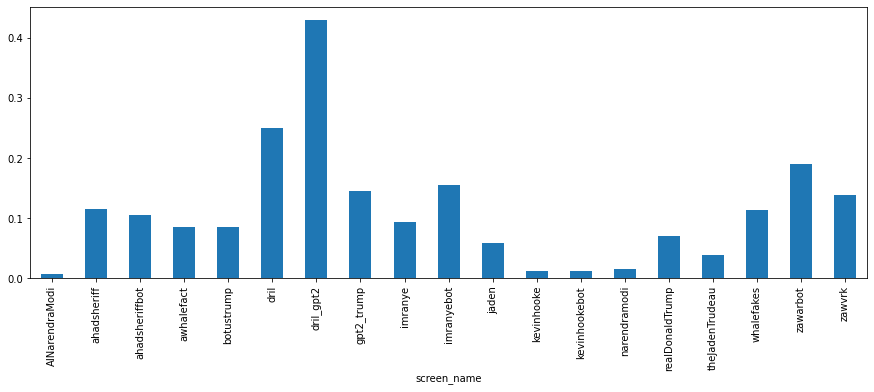

In [ ]:
plotErrorRatio(dfTest, "label_xlnet")